In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
#%matplotlib inline
%matplotlib nbagg
#%matplotlib notebook
#from sample.data import gen_kura_data
N = 400
D = 3
L = 2
T = 100
eta = 1
sigma = 0.1
resolution = 20

seed = 1
np.random.seed(seed)

In [116]:
def gen_saddle_shape(num_samples, random_seed=None, noise_scale=0.05):
    np.random.seed(seed)
    z1 = np.random.uniform(low=-1, high=+1, size=(num_samples,))
    z2 = np.random.uniform(low=-1, high=+1, size=(num_samples,))

    X = np.empty((num_samples, 3))
    X[:, 0] = z1
    X[:, 1] = z2
    X[:, 2] = 0.5 * (z1**2 - z2**2)
    X += np.random.normal(loc=0, scale=noise_scale, size=X.shape)

    return X

In [117]:
X = gen_saddle_shape(N)
print(X.shape)

(400, 3)


<IPython.core.display.Javascript object>


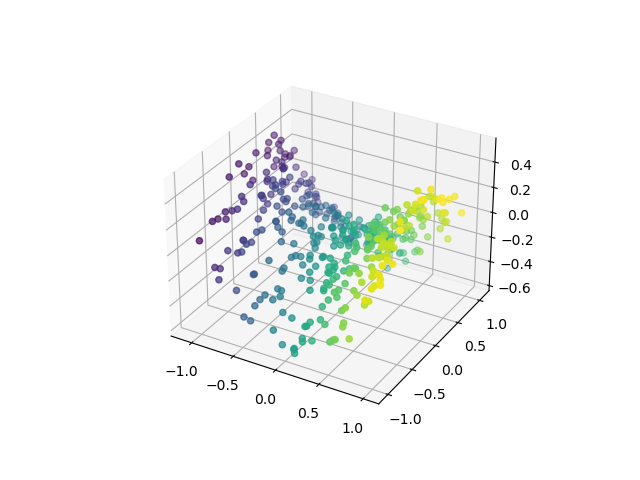

In [118]:
colormap = X[:, 0]
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap)
plt.show()

<IPython.core.display.Javascript object>


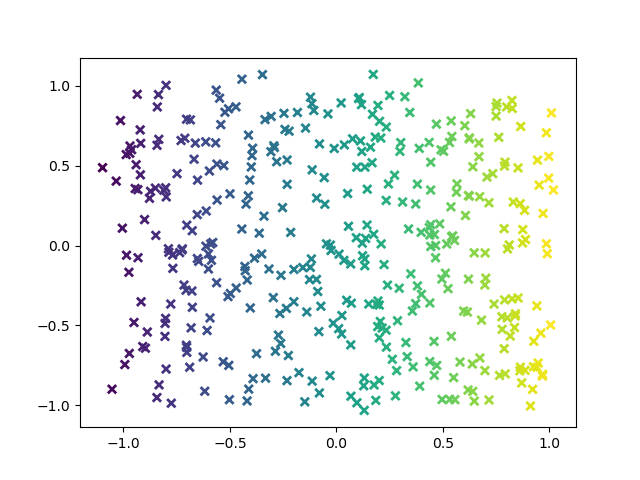

In [119]:
#真の潜在変数
plt.close()
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=colormap, marker='x', linewidth=2)
plt.show()

In [121]:
np.random.seed(seed)
Z = 2*np.random.rand(N, L)-1
Z *= 0.001
print(Z.shape)
#print(Z)

(400, 2)


<IPython.core.display.Javascript object>


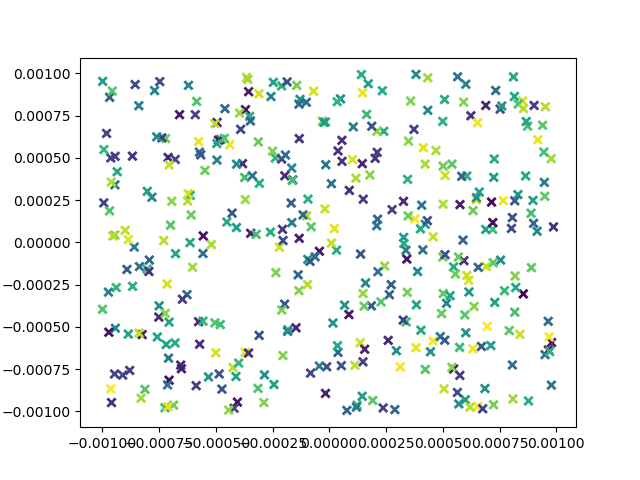

In [122]:
plt.close()
plt.scatter(Z[:, 0], Z[:, 1], c=colormap, marker='x', linewidth=2)

In [123]:
#データの距離
def distance(A, B):
    #Aはデータ(こっちで用意するやつ),Bは構造(ノード)(NxN)
    Dist = np.sum((A[:, None, :]-B[None, :, :])**2, axis=2)
    return Dist

In [124]:
#写像の推定
def estimate_y(Z1, Z2, X, sigma):
    #ガウス関数による重み行列k(z_n,z_i)(NxN)
    k = np.exp((-1/(2*(sigma**2)))*distance(Z1, Z2))
    #kをiでsumした行列K(z_n)(Nx1)
    K = np.sum(k, axis=1) 
    Y = (k@X)/K[:,None]
    return Y

In [125]:
#潜在変数の推定
def estimate_z(Z1, Z2, X, Y, sigma, eta):
    #ガウス関数による重み行列k(z_n,z_i)(NxN)
    k = np.exp((-1/(2*(sigma**2)))*distance(Z1, Z2))
    #kをiでsumした行列K(z_n)(Nx1)
    K = np.sum(k, axis=1)
    
    r = k/K[:,None]
    d = Y[:,None,:] - X[None,:,:]
    delta = Z1[:,None,:] - Z2[None,:,:]
    
    B = Y - X
    A = np.sum(B[:,None,:]*d,axis=2)
    
    C = r*A
    CC = C+C.T
    E_bibun = (2/(N*(sigma**2)))*np.sum(CC[:,:,None]*delta,axis=1)
    
    Z_new = Z1 - eta*E_bibun
    
    return Z_new 

In [126]:
y_hist=np.zeros((T,N,D))
z_hist=np.zeros((T,N,L))

for t in range(T):
    Y = estimate_y(Z, Z, X, sigma)
    Z = estimate_z(Z, Z, X, Y, sigma, eta)
    z_hist[t]=Z
    
    A = np.linspace(Z[:,0].min(),Z[:,0].max(),resolution)
    B = np.linspace(Z[:,1].min(),Z[:,1].max(),resolution)
    XX, YY = np.meshgrid(A,B)
    M = np.concatenate([XX.reshape(-1)[:,None], YY.reshape(-1)[:,None]], axis=1)
    
    Y_view = estimate_y(M, Z, X, sigma)
    y_hist[t]=Y_view

In [127]:
#潜在変数描画奴
def update(i):
    ax1.cla()
    ax2.cla()
    Z = z_hist[i]
    Y = y_hist[i]
    
    plt.title(f"学習回数{i+1}回目", fontname="MS Gothic")
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap)
    ax1.plot_wireframe(Y[:, 0].reshape(resolution,resolution), Y[:, 1].reshape(resolution,resolution), Y[:, 2].reshape(resolution,resolution), color='k')
    #ax2.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D')
    ax2.set_xlim(z_hist[:,:,0].min()-0.1,z_hist[:,:,0].max()+0.1)
    ax2.set_ylim(z_hist[:,:,1].min()-0.1,z_hist[:,:,1].max()+0.1)
    ax2.scatter(Z[:, 0], Z[:, 1], c=colormap, marker='x', linewidth=2)

<IPython.core.display.Javascript object>


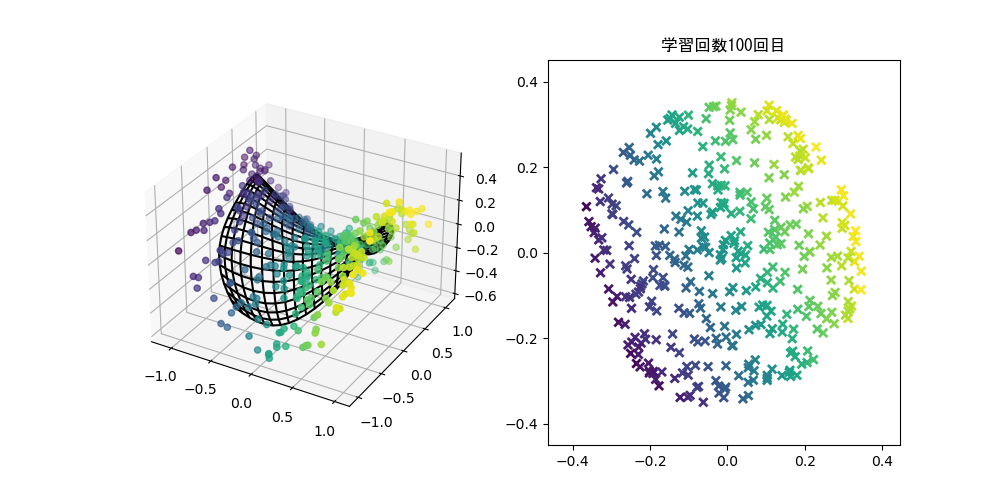

In [128]:
#潜在変数アニメーション
plt.close()
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
viewer = animation.FuncAnimation(fig=fig, func=update, frames=range(T), repeat=True)
plt.show()

<IPython.core.display.Javascript object>


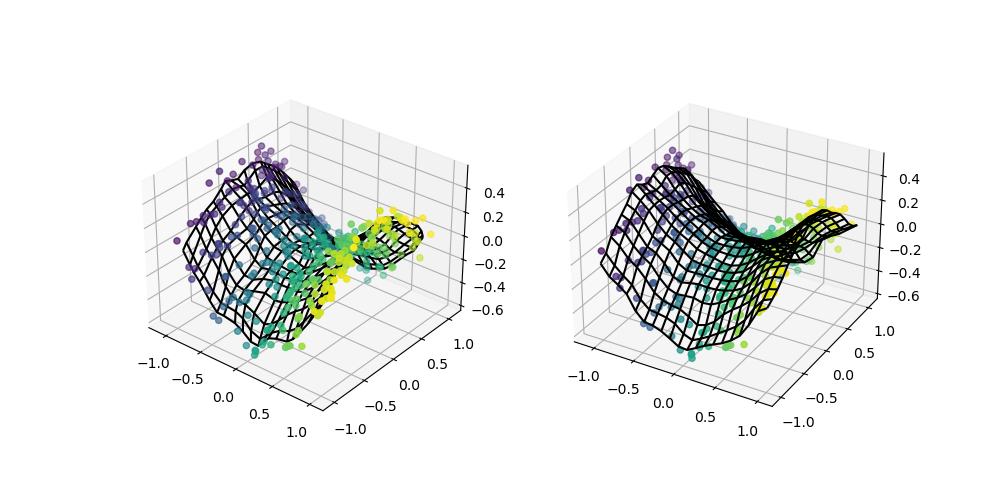

In [43]:
#テスト用セル
plt.close()
fig = plt.figure(figsize=(10,5))
#fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
#ax2 = fig.add_subplot(122)
#viewer = animation.FuncAnimation(fig=fig, func=update, frames=range(T), repeat=True)
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap)
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap)
A = np.linspace(-1,1,resolution)
B = np.linspace(-1,1,resolution)
XX, YY = np.meshgrid(A,B)
M = np.concatenate([XX.reshape(-1)[:,None], YY.reshape(-1)[:,None]], axis=1)
Z_test=np.zeros((N,L))
np.random.seed(seed)
z1 = np.random.uniform(low=-1, high=+1, size=(N,))
z2 = np.random.uniform(low=-1, high=+1, size=(N,))
Z_test[:,0]=z1
Z_test[:,1]=z2
#Y = estimate_y(Z, Z, X, sigma)
#Z = estimate_z(Z, Z, X, Y, sigma, eta)
ZZ = estimate_y(M ,Z_test, X, sigma)
ax1.plot_wireframe(ZZ[:,0].reshape(resolution,resolution), ZZ[:,1].reshape(resolution,resolution), ZZ[:,2].reshape(resolution,resolution), color='k')
ax2.plot_wireframe(XX, YY, ZZ[:,2].reshape(resolution,resolution), color='k')
#ax2.scatter(Z[:, 0], Z[:, 1], c=colormap, marker='x', linewidth=2)
#ax1.scatter(ZZ[:, 0], ZZ[:, 1], ZZ[:, 2], c='k')
plt.show()

In [4]:
a=np.ones((10,10,3))
print(a[:,:,0].shape)

(10, 10)
